# José Lucas Costa de Oliveira - UEPB



## Player Unknown's BattleGrounds (PUBG) 
## Análise de sobrevivência usando o estimador de  Kaplan-Meier

### PUBG é um jogo multiplayer online de battle royale. Este tipo de jogo significa que o vencedor é o último jogador/equipe que permanece vivo. Normalmente, a partida dura no máximo 30-35 minutos. Normalmente na análise de sobrevivência, espera-se algumas (ou muitas) observações censuradas à medida que algumas das observações "caem" ou chegam ao final do estudo sem um evento. No caso desta base de dados, não há "variável de censura" pois apenas um evento (morte de jogador) é registrado. É, porém, possível que, se o jogador se desconectar do jogo (mas não for morto), seja contado como morte de qualquer maneira.

## Pacotes

In [4]:
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings("ignore")

### Importando os dados

#### Fazendo mudança no tipo das proprias variáveis pra diminuir o processamento e carregar melhor os dados


In [7]:
cols= {'match_id':'object','game_size': 'int32', 'match_mode': 'category', 'party_size': 'category', 'player_assists':'int32', 'player_dbno':'int32', 'player_dist_ride': 'float32', 'player_dist_walk':'float32', 'player_dmg':'int32', 'player_kills':'int32', 'player_survive_time':'float32', 'team_id': 'int32', 'team_placement': 'int32'}
df= pd.read_csv('agg_match_stats_0.csv', nrows= 100000, dtype= cols)

### Descrição das variáveis

* date = Data da partida  
*  game_size = Tamanho de player na partida 
*  match_id = Registro da partida
*  match_mode = Modo do jogo
*  party_size = Modos do jogo (solo, duo, squad)
*  player_assists = Assistências dos jogadores 
*  player_dbno = Está caindo (quando o player perde toda sua vida mas não está morto)
*  player_dist_ride = Distância percorrida com veiculos 
*  player_dist_walk = Distância percorrida com passos
*  player_dmg = Dano do jogador na partida
*  player_kills = Abates do jogador na partida
*  player_name = Nome do jogador
*  player_survive_time  = Tempo de sobrevivencia do player na partida
*  team_id =  Identificação do time
*  team_placement = Colocação da equipe

## Fazendo uma breve análise descritiva de todos os dados

In [8]:
display(df.describe(include='all'))

,Unnamed: 0,date,game_size,match_id,match_mode,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_name,player_survive_time,team_id,team_placement
count,100000.000000,100000,100000.000000,100000,100000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,99858,100000.000000,100000.000000,100000.000000
unique,NaN,1082,NaN,1082,1,3,NaN,NaN,NaN,NaN,NaN,NaN,96667,NaN,NaN,NaN
top,NaN,2018-01-01T13:56:11+0000,NaN,2U4GBNA0YmlyPONrvBsCyyZ-ms1sEOi2R5nnKkT4bBv6od...,tpp,4,NaN,NaN,NaN,NaN,NaN,NaN,immj,NaN,NaN,NaN
freq,NaN,100,NaN,100,100000,47860,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN
mean,49999.500000,NaN,46.099080,NaN,NaN,NaN,0.227860,0.596350,1134.714600,1272.789795,124.065460,0.887540,NaN,784.129944,18950.730810,23.935030
std,28867.657797,NaN,24.172048,NaN,NaN,NaN,0.570108,1.146338,1931.980835,3308.657471,171.084255,1.573549,NaN,575.716431,39183.520596,19.748935
min,0.000000,NaN,13.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,51.789001,1.000000,1.000000
25%,24999.750000,NaN,27.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,209.018978,0.000000,0.000000,NaN,246.633747,11.000000,10.000000
50%,49999.500000,NaN,42.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,841.860962,77.000000,0.000000,NaN,648.817017,21.000000,19.000000
75%,74999.250000,NaN,50.000000,NaN,NaN,NaN,0.000000,1.000000,1860.138855,2058.608398,175.000000,1.000000,NaN,1294.531006,42.000000,31.000000


## Pegando agora apenas as colunas a serem utilizadas 

In [9]:
df[['game_size','party_size','player_survive_time','player_dist_ride','player_dmg']].describe(include='all')

,game_size,party_size,player_survive_time,player_dist_ride,player_dmg
count,100000.000000,100000,100000.000000,100000.000000,100000.000000
unique,NaN,3,NaN,NaN,NaN
top,NaN,4,NaN,NaN,NaN
freq,NaN,47860,NaN,NaN,NaN
mean,46.099080,NaN,784.129944,1134.714600,124.065460
std,24.172048,NaN,575.716431,1931.980835,171.084255
min,13.000000,NaN,51.789001,0.000000,0.000000
25%,27.000000,NaN,246.633747,0.000000,0.000000
50%,42.000000,NaN,648.817017,0.000000,77.000000
75%,50.000000,NaN,1294.531006,1860.138855,175.000000


### Aqui podemos verifcar algumas coisas como a média de tempo de jogo que fica em torno de 784 segundos mas em contrapartida temos um desvio padrão alto que fica em torno de 575 segundos, temos também que o modo mais jogado é o squad que são 4 players, também podemos observar nos dados que a média de dano por jogador é de 124 de dano com um desvio padrão maior que sua média sendo assim não sendo a melhor medida para se obter quanto ao dano dos jogadores, sendo assim essa é uma breve análise batendo o olho nos dados.

## Distribuição do tempo de sobrevivência 

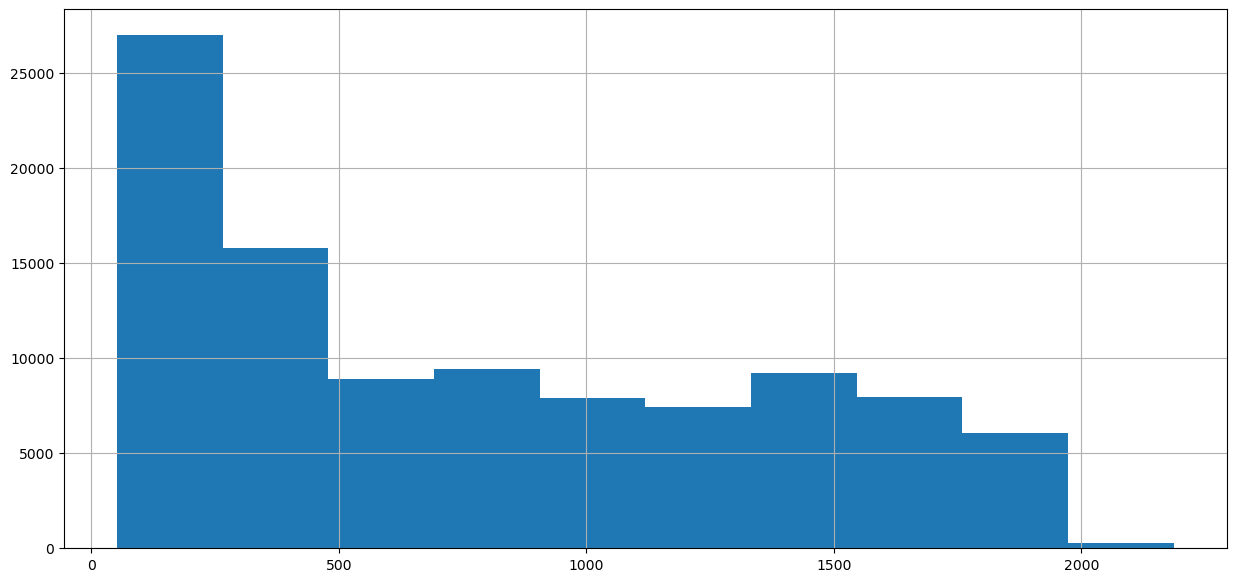

In [10]:
df['player_survive_time'].hist(figsize=(15,7))

plt.show();

### Podemos observar que os dados são assimétricos a direita ou sendo assim, são assimétricos positivamente.

## Nós comandos abaixo estão sendo feitos as separações dos dados utilizando o pandasql e assim atribuindo variáveis que serão utilizados no modelo final de kaplan meier.

#### solo

In [7]:
query = """

select distinct player_name, party_size, player_survive_time from df
where party_size = 1

"""
solo = ps.sqldf(query, locals())
solo

,player_name,party_size,player_survive_time
0,Satch,1,186.998993
1,osamabinlaggon,1,124.781998
2,dengboyu76,1,839.161011
3,GOGingmimi,1,751.716003
4,AtomicBrunette,1,744.088013
...,...,...,...
211477,Skelekat,1,844.242004
211478,vlac,1,120.924004
211479,Nk_Tobi_,1,1806.453979
211480,NickSK73,1,538.026978


#### duo

In [8]:
query = """

select distinct player_name, party_size, player_survive_time from df
where party_size = 2

"""
duo = ps.sqldf(query, locals())
duo

,player_name,party_size,player_survive_time
0,SnuffIes,2,1106.319946
1,Ozon3r,2,1106.314941
2,bovize,2,235.557999
3,sbahn87,2,197.552994
4,GeminiZZZ,2,1537.494995
...,...,...,...
318585,backupbuddy,2,735.205017
318586,ranbaobao1994,2,340.696014
318587,KingBestJx,2,354.881012
318588,bigjjgodness,2,1323.099976


#### squad

In [9]:
query = """

select distinct player_name, party_size, player_survive_time from df
where party_size = 4

"""
squad = ps.sqldf(query, locals())
squad

,player_name,party_size,player_survive_time
0,Toronto_Edision,4,1767.087036
1,Toronto_JackMa,4,1767.087036
2,Ok3yDok3y,4,1767.087036
3,LpeidonG,4,905.129028
4,WULEQI,4,905.125000
...,...,...,...
469922,Atlantis-Ll,4,1486.532959
469923,Atlantis-yu,4,1487.540039
469924,Long-Fickle,4,802.557983
469925,JangShuo,4,1630.927002


#### Transformando a coluna em boleano para poder ser trabalhada com ela 

In [10]:
df['player_dist_ride']= np.where(df['player_dist_ride']>0,1,df['player_dist_ride'])
df['player_dist_ride']=df['player_dist_ride'].astype('int')

In [11]:
df['player_dist_ride'].dtype

dtype('int32')

#### andando_correndo

In [12]:
query = """

select distinct player_name, player_dist_ride, player_survive_time from df
where player_dist_ride = 0

"""
andando_correndo = ps.sqldf(query, locals())
andando_correndo 

,player_name,player_dist_ride,player_survive_time
0,bovize,0,235.557999
1,sbahn87,0,197.552994
2,R1dd1ck913,0,1264.791992
3,Emmylou89,0,1264.795044
4,ron-n,0,868.559998
...,...,...,...
579184,duzhadan,0,724.890015
579185,backupbuddy,0,735.205017
579186,ranbaobao1994,0,340.696014
579187,KingBestJx,0,354.881012


#### dirigindo

In [13]:
query = """

select distinct player_name, player_dist_ride, player_survive_time from df
where player_dist_ride > 0

"""
dirigindo  = ps.sqldf(query, locals())
dirigindo


,player_name,player_dist_ride,player_survive_time
0,SnuffIes,1,1106.319946
1,Ozon3r,1,1106.314941
2,GeminiZZZ,1,1537.494995
3,AlexWho6,1,1537.500000
4,MatthiasXIV,1,1939.845947
...,...,...,...
420804,Boaba,1,1491.968018
420805,MoeKirito,1,1647.979004
420806,kkxej,1,979.185974
420807,UEatJer,1,979.182007


#### pequeno

In [14]:
query = """

select distinct player_name, game_size, player_survive_time from df
where game_size >= 0 and game_size <33

"""
pequeno = ps.sqldf(query, locals())
pequeno

,player_name,game_size,player_survive_time
0,Toronto_Edision,24,1767.087036
1,Toronto_JackMa,24,1767.087036
2,Ok3yDok3y,24,1767.087036
3,LpeidonG,24,905.129028
4,WULEQI,24,905.125000
...,...,...,...
471402,Atlantis-Ll,27,1486.532959
471403,Atlantis-yu,27,1487.540039
471404,Long-Fickle,27,802.557983
471405,JangShuo,27,1630.927002


#### grande

In [15]:
query = """

select distinct player_name, game_size, player_survive_time from df
where game_size >= 66 and game_size <= 100

"""
grande = ps.sqldf(query, locals())
grande

,player_name,game_size,player_survive_time
0,Satch,91,186.998993
1,osamabinlaggon,91,124.781998
2,dengboyu76,91,839.161011
3,GOGingmimi,91,751.716003
4,AtomicBrunette,91,744.088013
...,...,...,...
210825,Skelekat,88,844.242004
210826,vlac,88,120.924004
210827,Nk_Tobi_,88,1806.453979
210828,NickSK73,88,538.026978


#### medio

In [16]:
query = """

select distinct player_name, game_size, player_survive_time from df
where game_size >= 33 and game_size <66

"""
medio = ps.sqldf(query, locals())
medio

,player_name,game_size,player_survive_time
0,SnuffIes,37,1106.319946
1,Ozon3r,37,1106.314941
2,bovize,37,235.557999
3,sbahn87,37,197.552994
4,GeminiZZZ,37,1537.494995
...,...,...,...
317757,backupbuddy,43,735.205017
317758,ranbaobao1994,43,340.696014
317759,KingBestJx,43,354.881012
317760,bigjjgodness,43,1323.099976


#### low

In [17]:
query = """

select distinct player_name, player_dmg, player_survive_time from df
where player_dmg <= 124.065460

"""
low = ps.sqldf(query, locals())
low


,player_name,player_dmg,player_survive_time
0,SnuffIes,117,1106.319946
1,bovize,67,235.557999
2,sbahn87,0,197.552994
3,AlexWho6,65,1537.500000
4,R1dd1ck913,0,1264.791992
...,...,...,...
664781,kkxej,59,979.185974
664782,UEatJer,0,979.182007
664783,ranbaobao1994,21,340.696014
664784,KingBestJx,0,354.881012


#### high

In [18]:
query = """

select distinct player_name, player_dmg, player_survive_time from df
where player_dmg > 124.065460

"""
high = ps.sqldf(query, locals())
high

,player_name,player_dmg,player_survive_time
0,Ozon3r,127,1106.314941
1,GeminiZZZ,175,1537.494995
2,GucciManeDrain,215,180.901001
3,ShuLanHou,673,2009.722046
4,Hathawayxu,184,1880.072998
...,...,...,...
335209,Boaba,269,1491.968018
335210,MoeKirito,148,1647.979004
335211,duzhadan,143,724.890015
335212,backupbuddy,197,735.205017


####  Utilizando a função de kaplan maier

In [19]:
kmf = KaplanMeierFitter()

# Gráfico dos 3 tipos de modo de jogo 

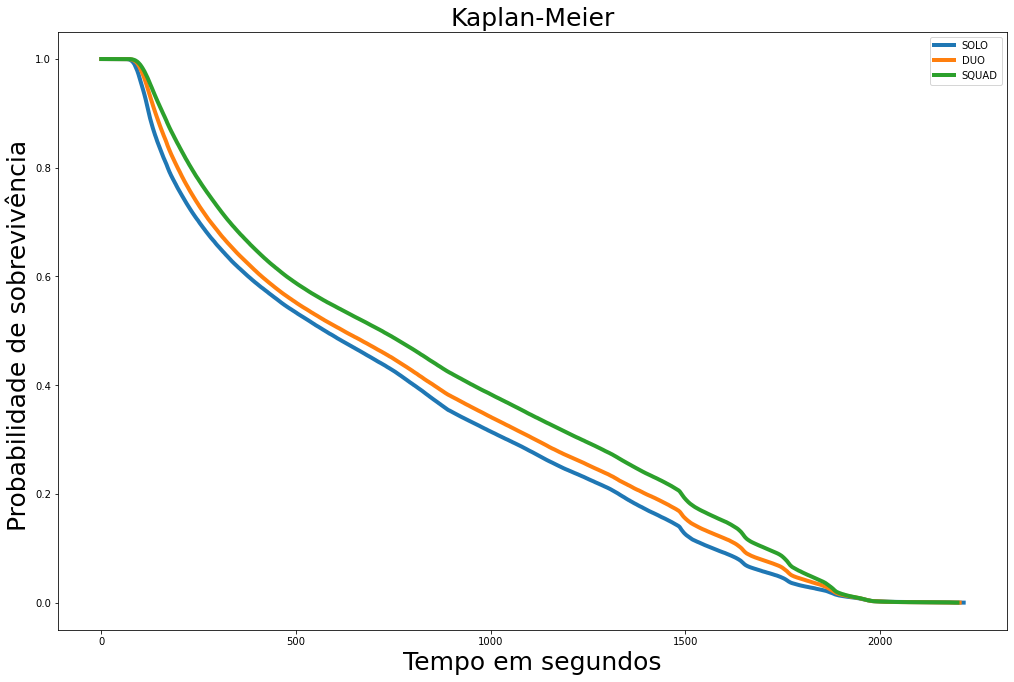

In [20]:
fig,ax = plt.subplots(figsize=(17,11))

kmf.fit(durations= solo['player_survive_time'], event_observed= solo['party_size'],label= 'SOLO')
kmf.survival_function_.plot(ax=ax,lw=4)

kmf.fit(durations=  duo['player_survive_time'], event_observed= duo['party_size'],label= 'DUO')
kmf.survival_function_.plot(ax=ax,lw=4)

kmf.fit(durations= squad['player_survive_time'], event_observed= squad['party_size'],label= 'SQUAD')
kmf.survival_function_.plot(ax=ax,lw=4)


plt.title('Kaplan-Meier',fontsize=25)
plt.xlabel('Tempo em segundos',fontsize=25)
plt.ylabel('Probabilidade de sobrevivência ',fontsize=25)
 

plt.show();

### Como análise temos que a medida que o tempo passa se você joga sozinho tem mais probabilidade de sobrevivência no jogo do que uma pessoa que joga em squad, com base nisso e com os jogos tem-se que se você jogar com mais pessoa você cconsegue chegar mais longe que jogando PUBG sozinho sendo assim podemos tirar como conclusão que jogando em squad você tem mais probabilidades de chegar mais longe.

## Teste de log-rank

In [21]:
results=logrank_test(solo['player_survive_time'],duo['player_survive_time'], event_observed_A=solo['party_size'],event_observed_B=duo['party_size'])
results.print_summary()

results=logrank_test(solo['player_survive_time'],squad['player_survive_time'], event_observed_A=solo['party_size'],event_observed_B=squad['party_size'])
results.print_summary()

results=logrank_test(duo['player_survive_time'],squad['player_survive_time'], event_observed_A=duo['party_size'],event_observed_B=squad['party_size'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1006.79 <0.005    731.56

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        5718.94 <0.005       inf

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2170.74 <0.005       inf

##### hipoteses a serem testadas pelo teste de log-rank
  - hipótese nula: Não existe nenhuma diferença na probabilidade do evento entre os grupos
  - hipótese alternativa: Existe diferença na probabilidade do evento entre os grupos

### Com base no teste de log-rank podemos ver que o p-valor da abaixo de 0.05 que indica que Existem diferença entre os grupos.

# Gráfico dos 3 tipos de jogadores

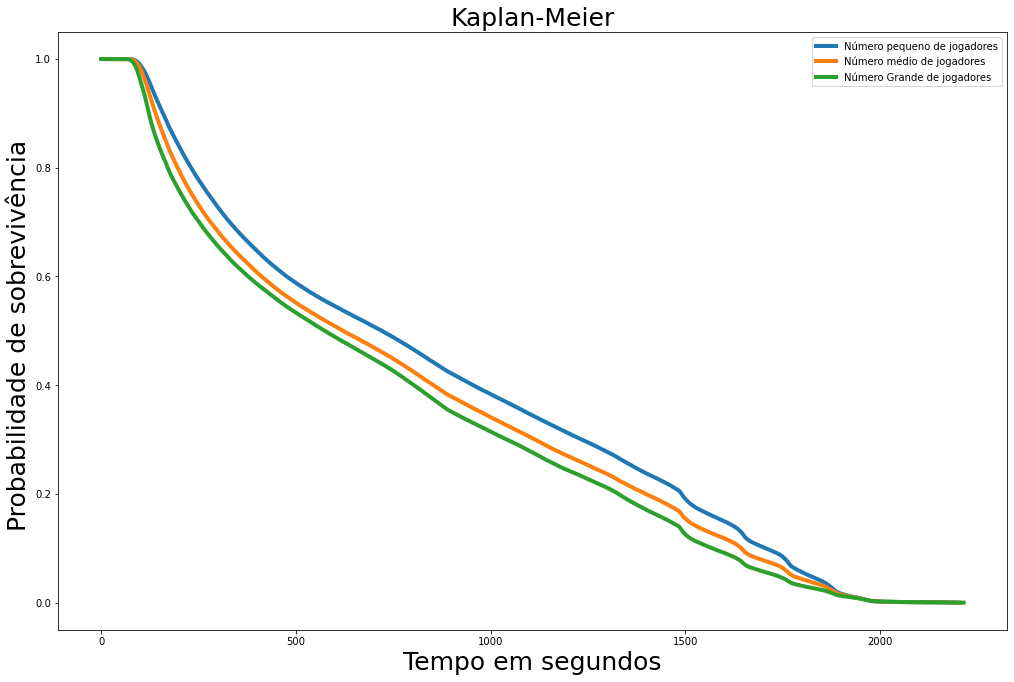

In [22]:
fig,ax = plt.subplots(figsize=(17,11))

kmf.fit(durations= pequeno['player_survive_time'], event_observed= pequeno['game_size'],label= 'Número pequeno de jogadores')
kmf.survival_function_.plot(ax=ax,lw=4)

kmf.fit(durations= medio['player_survive_time'], event_observed= medio['game_size'],label= 'Número médio de jogadores')
kmf.survival_function_.plot(ax=ax,lw=4)

kmf.fit(durations= grande['player_survive_time'], event_observed= grande['game_size'],label= 'Número Grande de jogadores')
kmf.survival_function_.plot(ax=ax,lw=4)


plt.title('Kaplan-Meier',fontsize=25)
plt.xlabel('Tempo em segundos',fontsize=25)
plt.ylabel('Probabilidade de sobrevivência ',fontsize=25)
 

plt.show();

### Com esse gráfico de sobrevivência podemos observar que quanto menos pessoa tem no mapa, tem-se uma probabilidade de sobrevivência maior que os demais grupos, sendo assim pelo contexto do jogo faz sentido, como o jogo é de mundo aberto temos que com menos jogadores, menos confrontos tem-se entre si, sendo assim demora mais para encontrar jogadores para eliminar. 

## Teste de log-rank

In [23]:
results=logrank_test(pequeno['player_survive_time'],medio['player_survive_time'], event_observed_A=pequeno['game_size'],event_observed_B=medio['game_size'])
results.print_summary()

results=logrank_test(pequeno['player_survive_time'],grande['player_survive_time'], event_observed_A=pequeno['game_size'],event_observed_B=grande['game_size'])
results.print_summary()

results=logrank_test(medio['player_survive_time'],grande['player_survive_time'], event_observed_A=medio['game_size'],event_observed_B=grande['game_size'])
results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2218.39 <0.005       inf

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        5785.83 <0.005       inf

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1004.74 <0.005    730.08

##### hipoteses a serem testadas pelo teste de log-rank
  - hipótese nula: Não existe nenhuma diferença na probabilidade do evento entre os grupos
  - hipótese alternativa: Existe diferença na probabilidade do evento entre os grupos

### Com base no teste de log-rank podemos ver que o p-valor da abaixo de 0.05 que indica que Existem diferença entre os grupos.

# Gráfico dos 2 tipos de dano

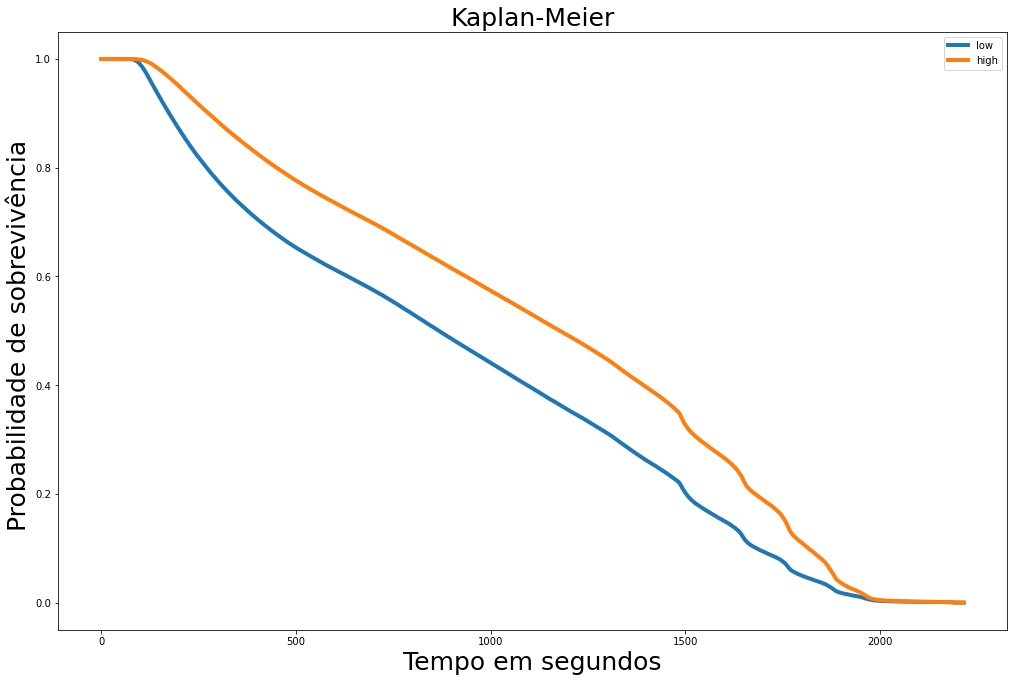

In [24]:
fig,ax = plt.subplots(figsize=(17,11))

kmf.fit(durations= low['player_survive_time'], event_observed= low['player_dmg'],label= 'low')
kmf.survival_function_.plot(ax=ax,lw=4)

kmf.fit(durations=  high['player_survive_time'], event_observed= high['player_dmg'],label= 'high')
kmf.survival_function_.plot(ax=ax,lw=4)


plt.title('Kaplan-Meier',fontsize=25)
plt.xlabel('Tempo em segundos',fontsize=25)
plt.ylabel('Probabilidade de sobrevivência ',fontsize=25)
 
plt.show();

### Nesse gráfico de sobrevivência temos que quanto mais dano você da na partida a probabilidade de sobrevivência é maior de quem da menos dano, e isso até logicamente tem-se que quem da mais dano nos games sobrevive ou ganha mais jogos dependendo da plataforma.

## Teste de log-rank

In [25]:
results=logrank_test(low['player_survive_time'],high['player_survive_time'], event_observed_A=low['player_dmg'],event_observed_B=high['player_dmg'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       22210.95 <0.005       inf

##### hipoteses a serem testadas pelo teste de log-rank
  - hipótese nula: Não existe nenhuma diferença na probabilidade do evento entre os grupos
  - hipótese alternativa: Existe diferença na probabilidade do evento entre os grupos

### Com base no teste de log-rank podemos ver que o p-valor da abaixo de 0.05 que indica que Existem diferença entre os grupos.